In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [8]:
# This module cleans the data

# Clean Data
df=pd.read_excel('./datasets/Datasetq2.xlsx')
df.index=df['Dates']

df=df.drop(columns=['Dates'])

#Decimalise the annualised risk-free rate
df['UK GVT BMK BID YLD 1M - RED. YIELD'] = df['UK GVT BMK BID YLD 1M - RED. YIELD'] / 100

# Convert the annualised risk-free rate to a monthly rate
df['Risk_Free_Return'] = df['UK GVT BMK BID YLD 1M - RED. YIELD'] / 12

# Identify risk-free rate and benchmark index columns
risk_free_column = 'Risk_Free_Return'
annualised_risk_free_column = 'UK GVT BMK BID YLD 1M - RED. YIELD'
benchmark_column = 'FTSE ALL SHARE - PRICE INDEX'

# Compute log returns for all columns except the risk-free rate.
for i in df.columns:
    if i not in [risk_free_column,annualised_risk_free_column]:
        df[i] = np.log(df[i] / df[i].shift(1))

# Drop the first date (since it will have NaN due to shift)
df=df.drop(df.index[0])

df.describe()
# Note: Compass Group and Centrica have NaNs. Why?
        #Centrica was not listed until 1997 - so all of these na need to be filled with 0.
        # Compass Group was initially listed in 1988, but merged with Granada. They demerged in Feb 2001, so CPG did not trade until then
            #Source: https://www.compass-group.com/en/investors/shareholder-centre/other-useful-information.html
# How do we fix this problem? fillna with 0 for both Centrica and Compass Group
df=df.fillna(0)

#Split dataset
pre_investment_period = df[df.index < '2014-10-31']
investment_period = df[df.index >= '2014-10-31']

#To help visualise the stocks only we can drop benchmark and risk free
pre_investment_period_stocks = pre_investment_period.drop(columns=[benchmark_column, risk_free_column,annualised_risk_free_column])

In [9]:
# Next step is to incorporate monthly returns, Sharpe ratios, and correlations with benchmark

avg_monthly_rf_rate=pre_investment_period[risk_free_column].mean()

stock_columns = pre_investment_period.columns.drop([benchmark_column, risk_free_column,annualised_risk_free_column])

# Initialise a DataFrame to store metrics
metrics = pd.DataFrame(index=stock_columns, columns=['Avg Monthly Return', 'Avg Monthly Std Dev', 'Sharpe Ratio', 'Correlation with Benchmark','Beta'])


#Create a marketbeta function
def marketbeta(Y, X):
    X = np.hstack([X, np.ones((X.shape[0], 1))])
    return np.linalg.lstsq(X, Y, rcond=None)[0][0]

# Calculate metrics for each stock
for stock in stock_columns:
    mean_monthly_return = pre_investment_period[stock].mean()
    monthly_std = pre_investment_period[stock].std()

    sharpe_ratio = (mean_monthly_return - avg_monthly_rf_rate) / monthly_std

    correlation = pre_investment_period[stock].corr(pre_investment_period[benchmark_column])

    beta = marketbeta(pre_investment_period[[stock]].values, pre_investment_period[[benchmark_column]].values)

    metrics.loc[stock, 'Avg Monthly Return'] = mean_monthly_return
    metrics.loc[stock, 'Avg Monthly Std Dev'] = monthly_std
    metrics.loc[stock, 'Sharpe Ratio'] = sharpe_ratio
    metrics.loc[stock, 'Correlation with Benchmark'] = correlation
    metrics.loc[stock, 'Beta'] = beta

metrics

,Avg Monthly Return,Avg Monthly Std Dev,Sharpe Ratio,Correlation with Benchmark,Beta
ASTRAZENECA,0.00576,0.067413,0.039412,0.288261,0.47194427675605755
RIO TINTO,0.006072,0.103909,0.028576,0.575097,1.451301420539549
BP,0.002313,0.06993,-0.011302,0.571033,0.9698195827268249
BRITISH AMERICAN TOBACCO,0.010446,0.068718,0.106863,0.293906,0.49050522552914605
DIAGEO,0.00585,0.049825,0.055137,0.411194,0.4975732205014655
ROLLS-ROYCE HOLDINGS,0.008526,0.092949,0.058348,0.57009,1.2869178573852251
COMPASS GROUP,0.002602,0.058645,-0.008547,0.447946,0.6379980088471554
TESCO,0.002808,0.064802,-0.004552,0.398538,0.6272254395589381
BAE SYSTEMS,0.003828,0.083904,0.008646,0.520142,1.0599116939995938
VODAFONE GROUP,0.006513,0.076702,0.044462,0.444797,0.8285786014465382


In [10]:
#Sort by Sharpe Ratio
top_stocks = metrics.sort_values(by='Sharpe Ratio', ascending=False)
top_stocks

,Avg Monthly Return,Avg Monthly Std Dev,Sharpe Ratio,Correlation with Benchmark,Beta
BRITISH AMERICAN TOBACCO,0.010446,0.068718,0.106863,0.293906,0.49050522552914605
BUNZL,0.009232,0.064169,0.095509,0.461017,0.7184696997864853
NATIONAL GRID,0.007117,0.052367,0.076646,0.351455,0.4469802038755892
SAGE GROUP,0.010753,0.102433,0.074685,0.571675,1.4221782245924524
CENTRICA,0.007387,0.062736,0.068293,0.384797,0.5862869690872228
WPP,0.008991,0.090647,0.064958,0.672177,1.479788386861504
ROLLS-ROYCE HOLDINGS,0.008526,0.092949,0.058348,0.57009,1.2869178573852251
DIAGEO,0.00585,0.049825,0.055137,0.411194,0.4975732205014655
VODAFONE GROUP,0.006513,0.076702,0.044462,0.444797,0.8285786014465382
ASTRAZENECA,0.00576,0.067413,0.039412,0.288261,0.47194427675605755


In [11]:
candidate_stocks=top_stocks.head(10).index.tolist()
print(candidate_stocks)

['BRITISH AMERICAN TOBACCO', 'BUNZL', 'NATIONAL GRID', 'SAGE GROUP', 'CENTRICA', 'WPP', 'ROLLS-ROYCE HOLDINGS', 'DIAGEO', 'VODAFONE GROUP', 'ASTRAZENECA']


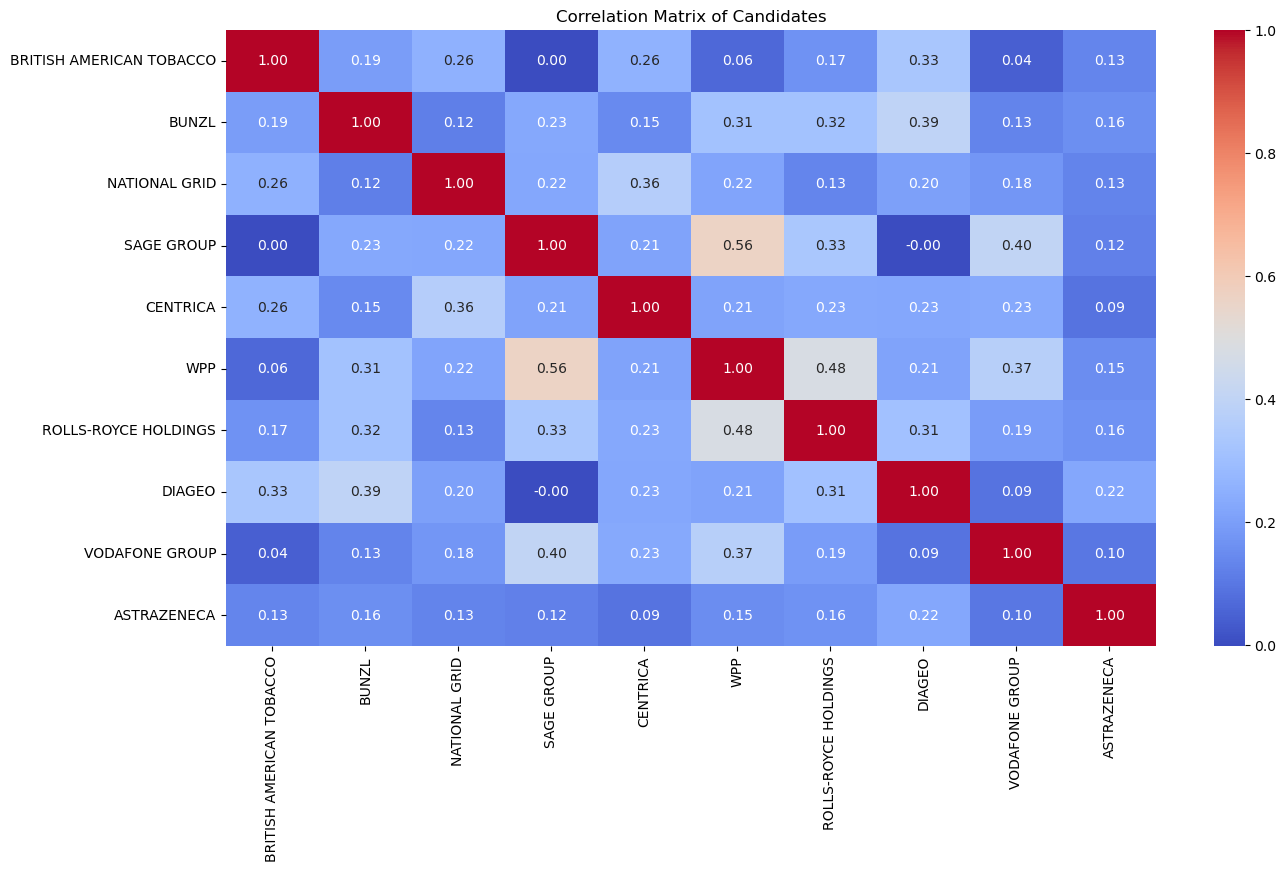

In [12]:
#Compute correlation matrix for candidate stocks
candidate_returns = pre_investment_period_stocks[candidate_stocks]
candidate_corr_matrix = candidate_returns.corr()

import seaborn as sns
plt.figure(figsize=(15, 8))
sns.heatmap(candidate_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Candidates")
plt.show()

In [13]:
#Generate all combinations of 5 stocks and compute average pairwise correlations

from itertools import combinations

stock_combinations = list(combinations(candidate_stocks, 5))

#Important Pairwise Correlation Calculation

def average_pairwise_correlation(stocks, corr_matrix):
    corr_values = corr_matrix.loc[stocks, stocks]
    mask = np.triu(np.ones(corr_values.shape), k=1).astype(bool)
    pairwise_corr = corr_values.where(mask)
    pairwise_corr = pairwise_corr.stack()
    return pairwise_corr.mean()

In [14]:
#Running pairwise correlation

combination_scores = []
for combo in stock_combinations:
    avg_corr = average_pairwise_correlation(combo, candidate_corr_matrix)
    combination_scores.append({'Stocks': combo, 'Avg_Correlation': avg_corr})

combination_scores_df = pd.DataFrame(combination_scores)
sorted_combinations = combination_scores_df.sort_values(by='Avg_Correlation')

Selected stocks: ('BRITISH AMERICAN TOBACCO', 'BUNZL', 'NATIONAL GRID', 'VODAFONE GROUP', 'ASTRAZENECA')
Average pairwise correlation: 0.1445


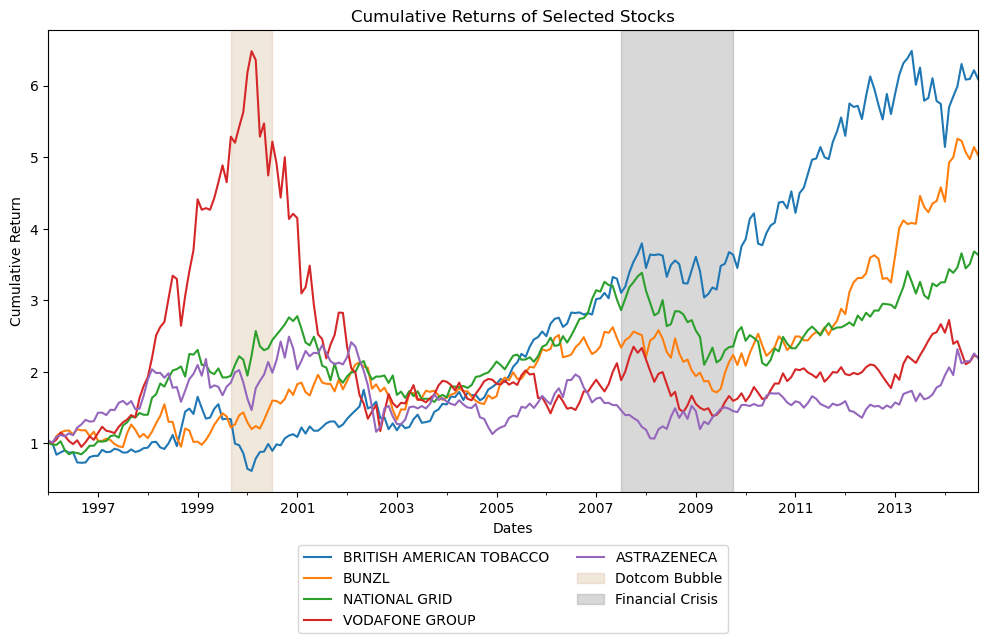

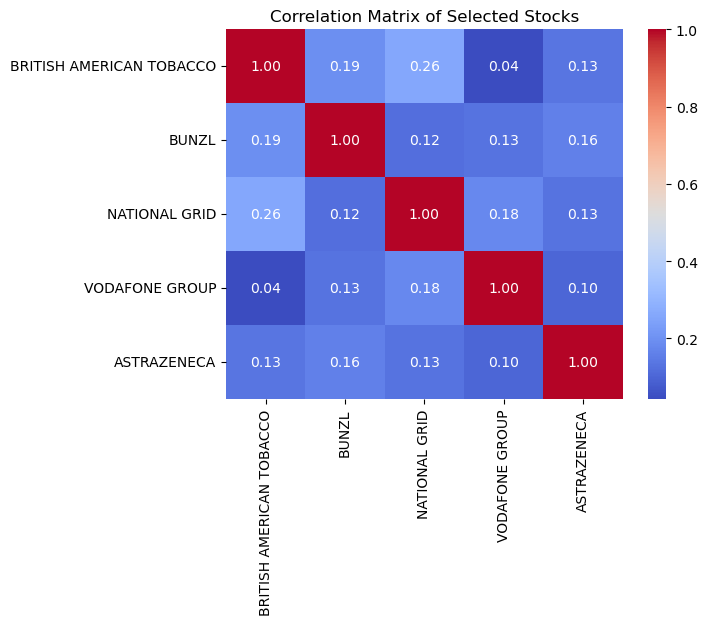

In [15]:
###Results of avg pairwise correlation, stocks selected, returns of stocks, and correlation matrix

best_combination = sorted_combinations.iloc[0]['Stocks']
best_avg_corr = sorted_combinations.iloc[0]['Avg_Correlation']

print(f"Selected stocks: {best_combination}")
print(f"Average pairwise correlation: {best_avg_corr:.4f}")



# Visualise cumulative returns
selected_returns = pre_investment_period_stocks[list(best_combination)]
cumulative_returns = (1 + selected_returns).cumprod()

ax = cumulative_returns.plot(figsize=(12,6))
plt.title("Cumulative Returns of Selected Stocks")
plt.ylabel("Cumulative Return")

#Show previous crises
plt.axvspan(pd.Timestamp("1999-09-01"),pd.Timestamp("2000-07-01"), color='tan',alpha=0.3, label="Dotcom Bubble")
plt.axvspan(pd.Timestamp("2007-07-01"), pd.Timestamp("2009-10-01"), color='gray', alpha=0.3, label="Financial Crisis")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.show()


#Visualize correlation matrix
selected_corr_matrix = selected_returns.corr()
sns.heatmap(selected_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Selected Stocks")
plt.show()

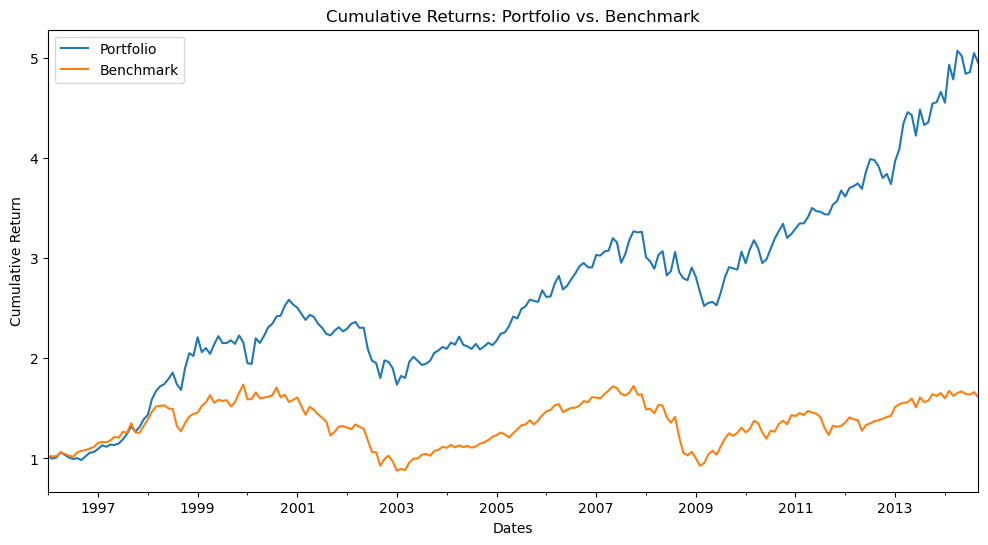

In [17]:
#Portfolio Returns vs Benchmark historically
portfolio_returns = selected_returns.mean(axis=1)

portfolio_cumulative = (1 + portfolio_returns).cumprod()
benchmark_cumulative = (1 + pre_investment_period[benchmark_column]).cumprod()

comparison_df = pd.DataFrame({'Portfolio': portfolio_cumulative,
                              'Benchmark': benchmark_cumulative})


comparison_df.plot(figsize=(12, 6))
plt.title("Cumulative Returns: Portfolio vs. Benchmark")
plt.ylabel("Cumulative Return")
plt.legend(loc='best')
plt.show()

In [ ]:
# Now let's run a portfolio optimisation to find minimum variance portfolio

In [20]:
selected_returns.keys()

Index(['BRITISH AMERICAN TOBACCO', 'BUNZL', 'NATIONAL GRID', 'VODAFONE GROUP',
       'ASTRAZENECA'],
      dtype='object')

Processing interval starting at 2014-10-31 00:00:00


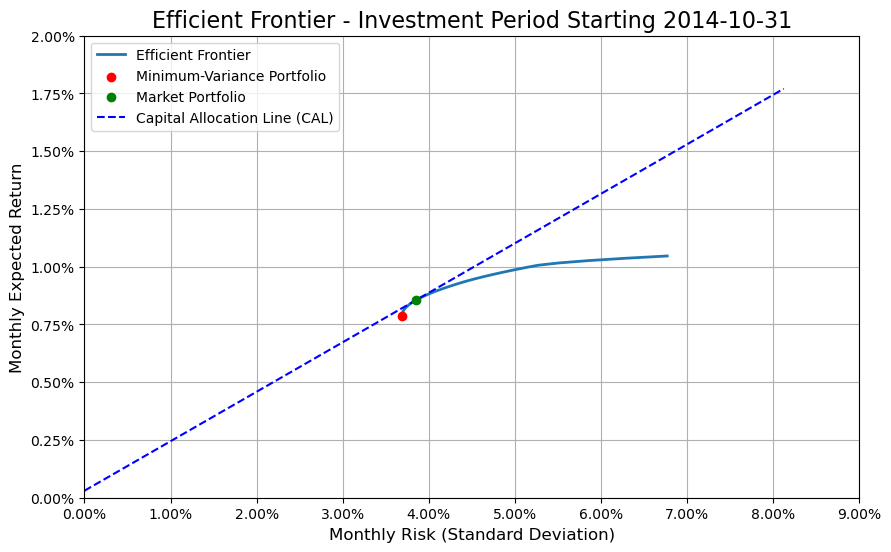

Processing interval starting at 2015-04-30 00:00:00


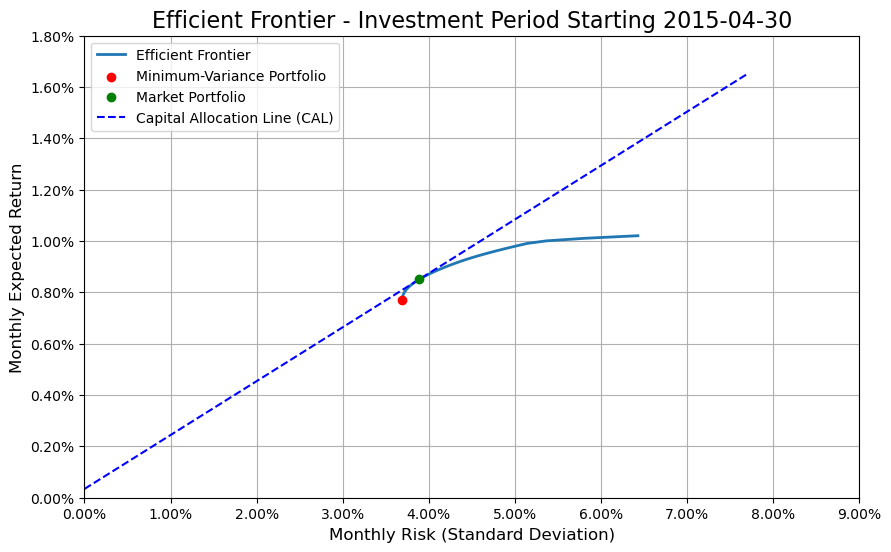

Processing interval starting at 2015-10-30 00:00:00


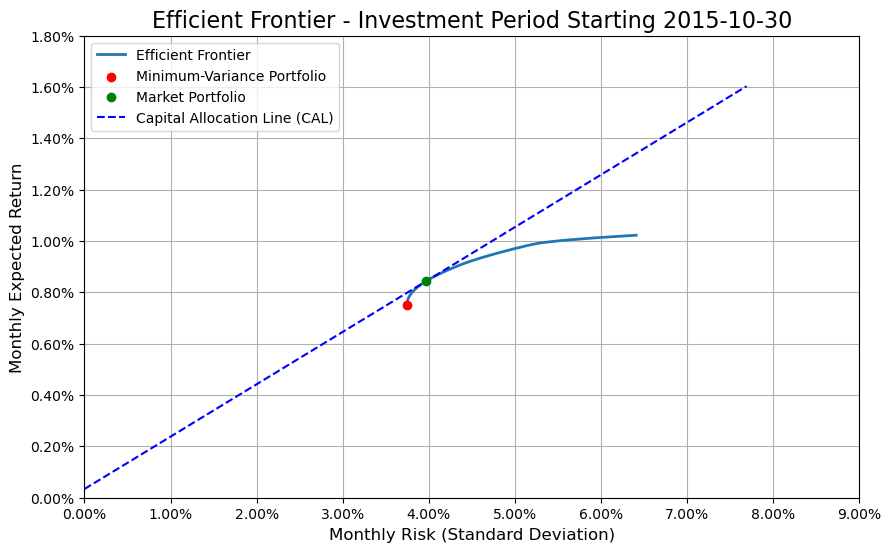

Processing interval starting at 2016-04-29 00:00:00


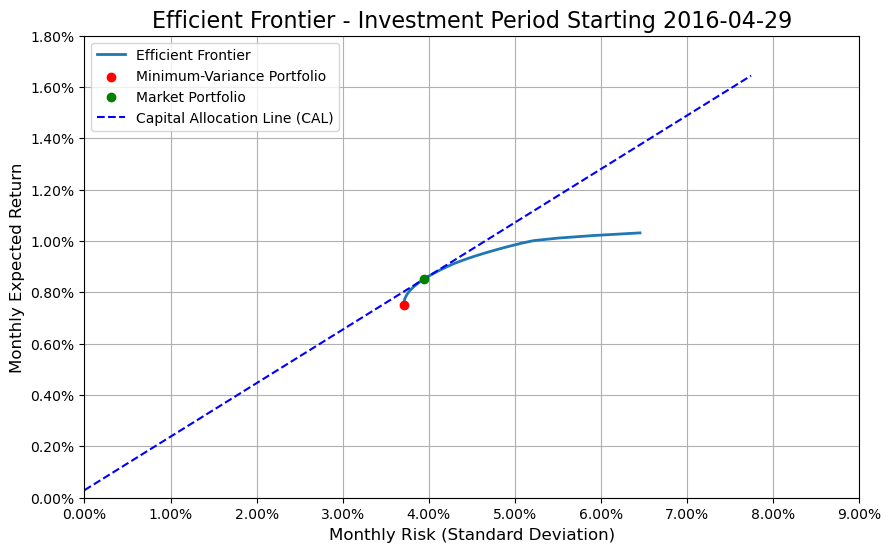

Processing interval starting at 2016-10-31 00:00:00


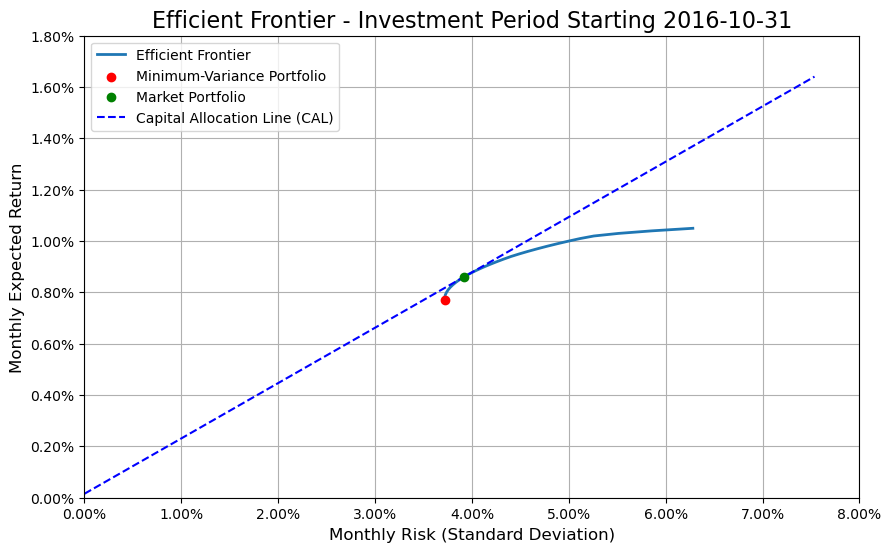

Processing interval starting at 2017-04-28 00:00:00


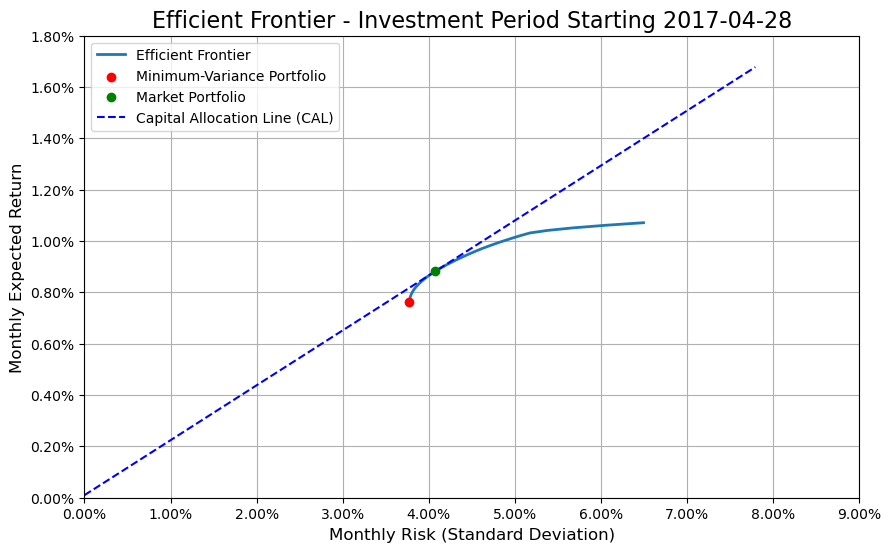

Processing interval starting at 2017-10-31 00:00:00


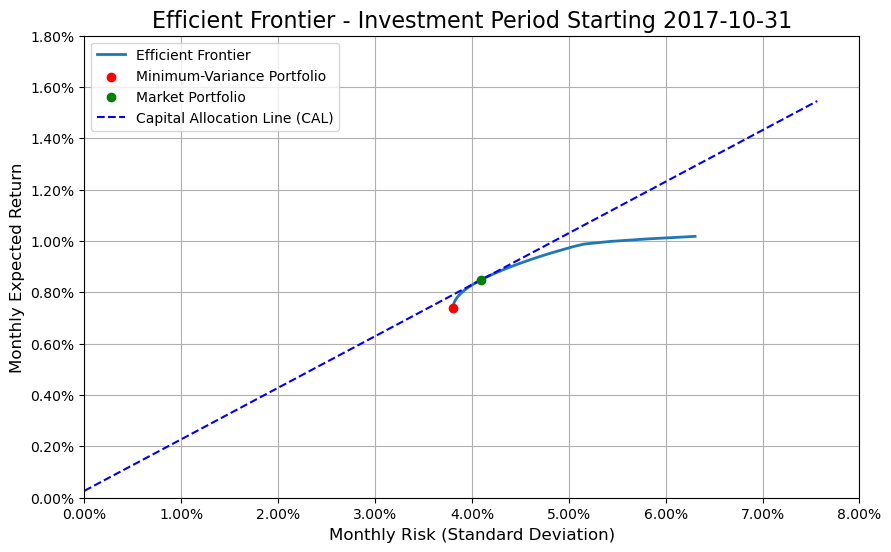

Processing interval starting at 2018-04-30 00:00:00


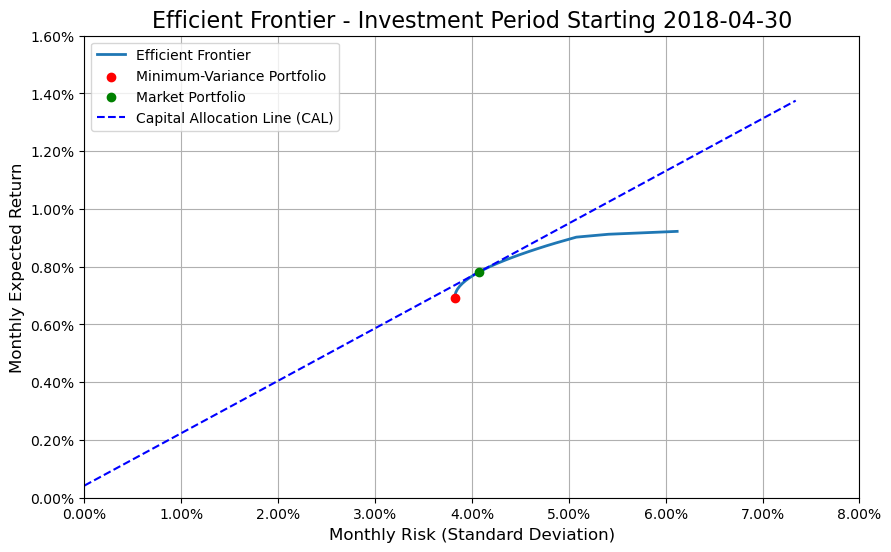

Processing interval starting at 2018-10-31 00:00:00


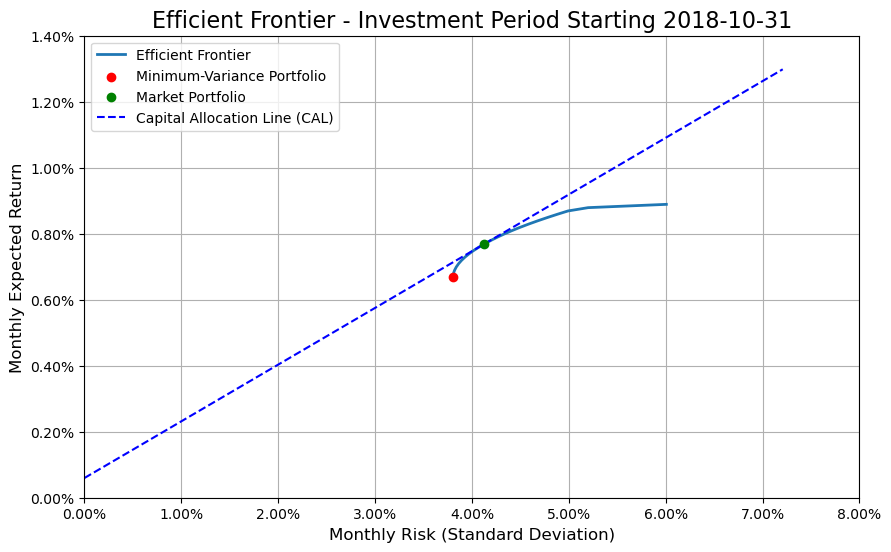

Processing interval starting at 2019-04-30 00:00:00


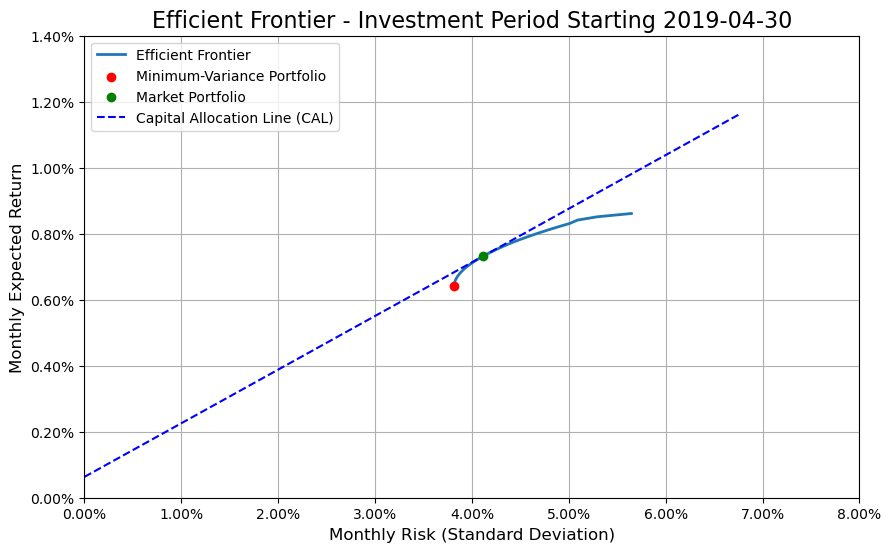

Processing interval starting at 2019-10-31 00:00:00


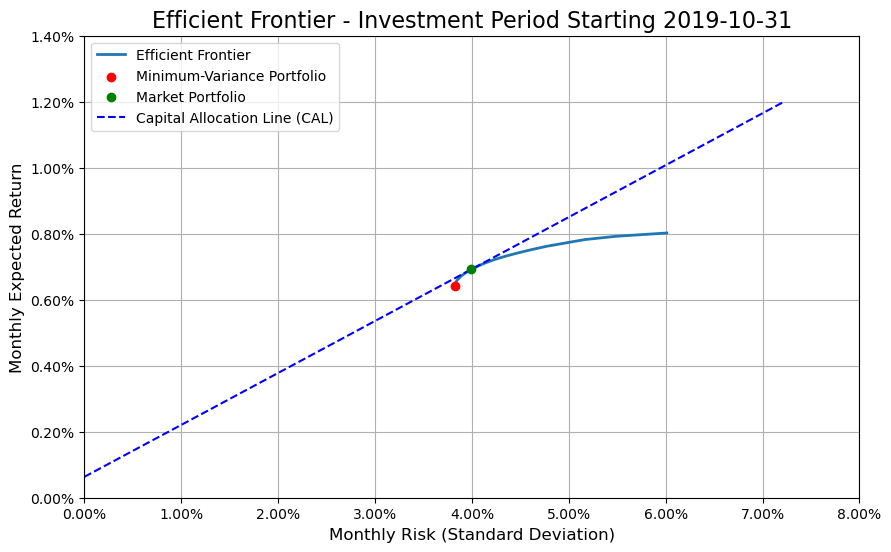

Processing interval starting at 2020-04-30 00:00:00


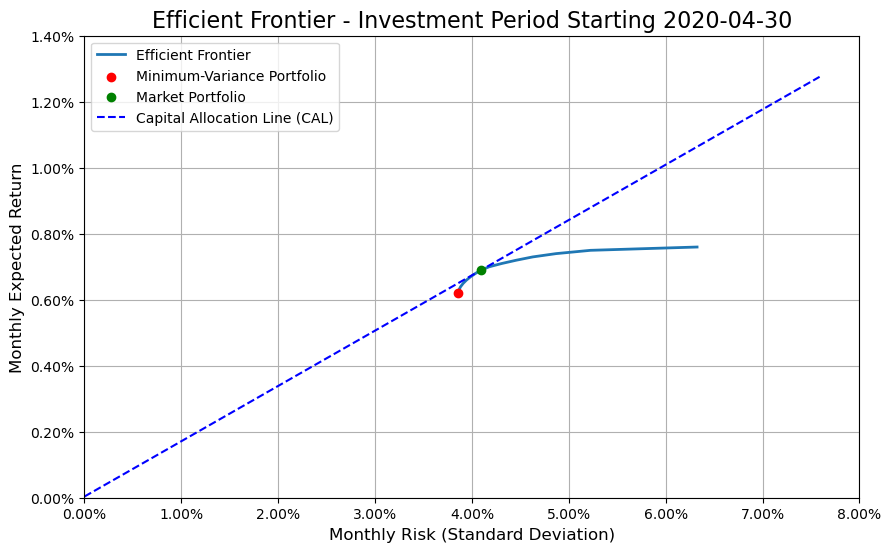

Processing interval starting at 2020-10-30 00:00:00


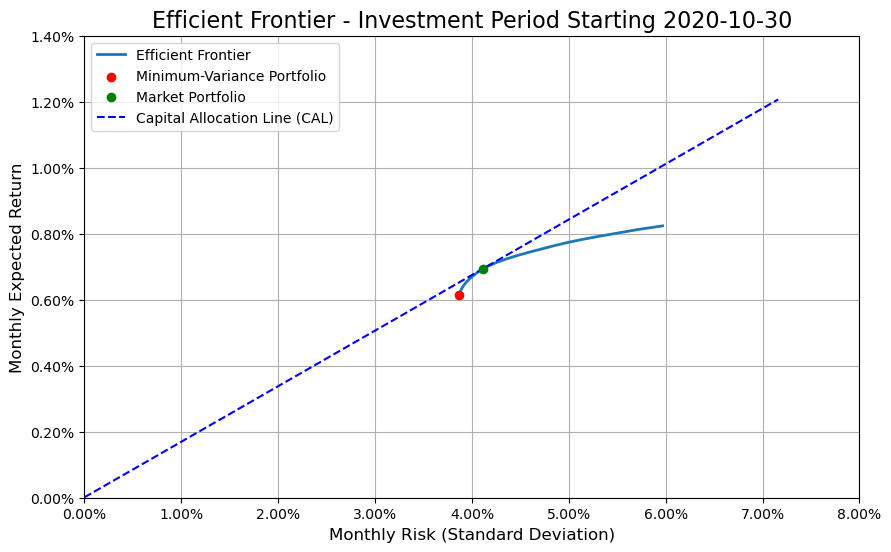

Processing interval starting at 2021-04-30 00:00:00


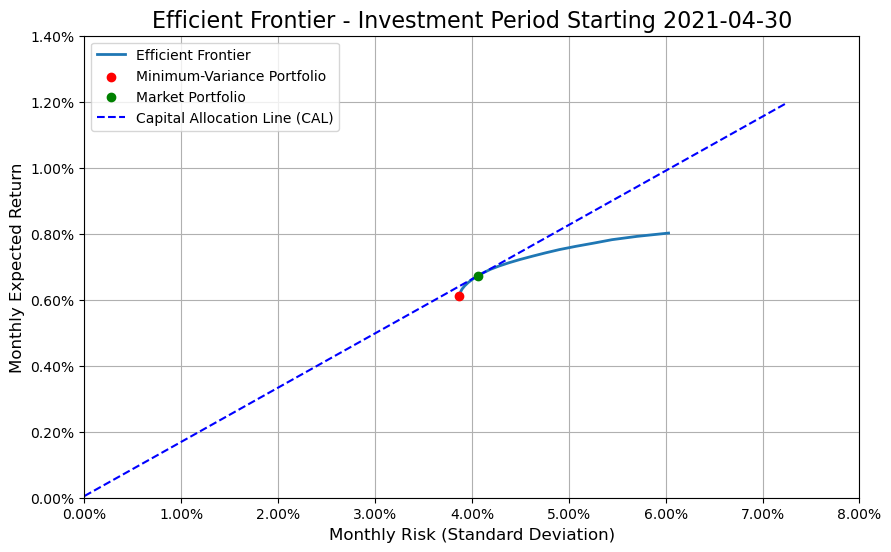

Processing interval starting at 2021-10-29 00:00:00


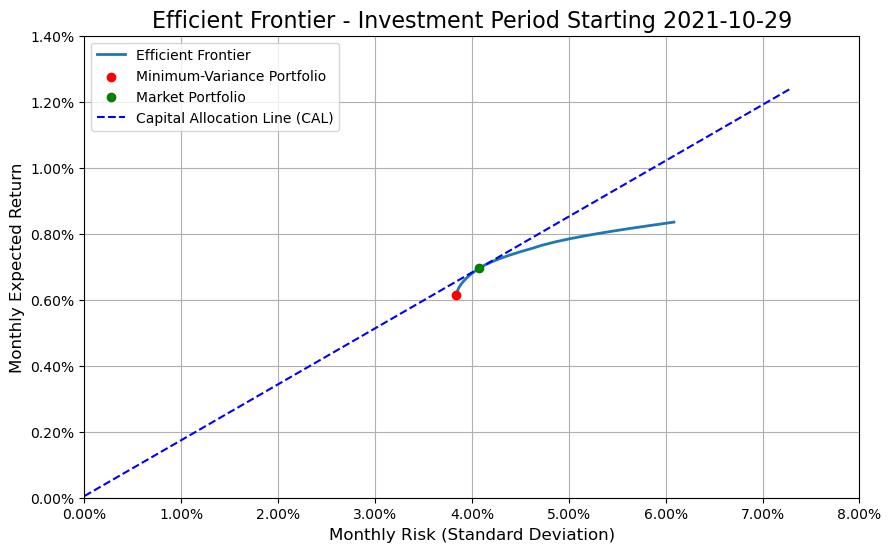

Processing interval starting at 2022-04-29 00:00:00


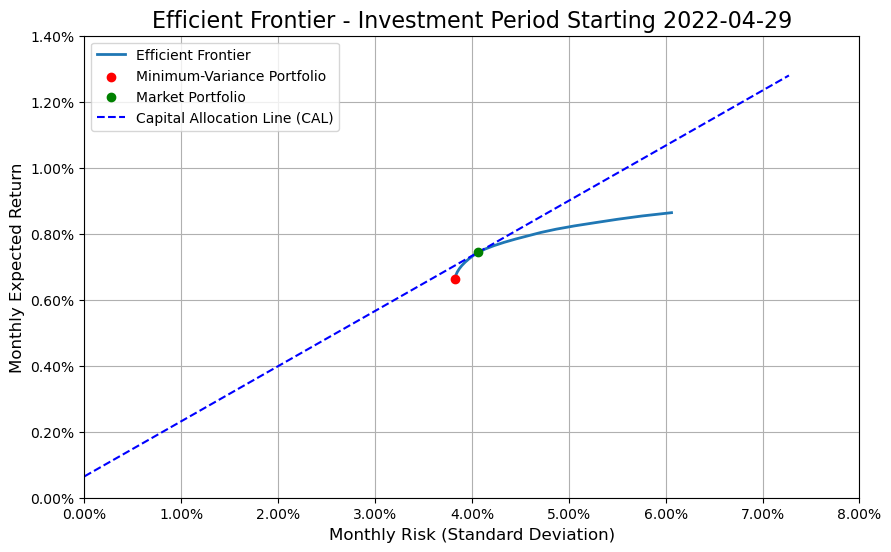

Processing interval starting at 2022-10-31 00:00:00


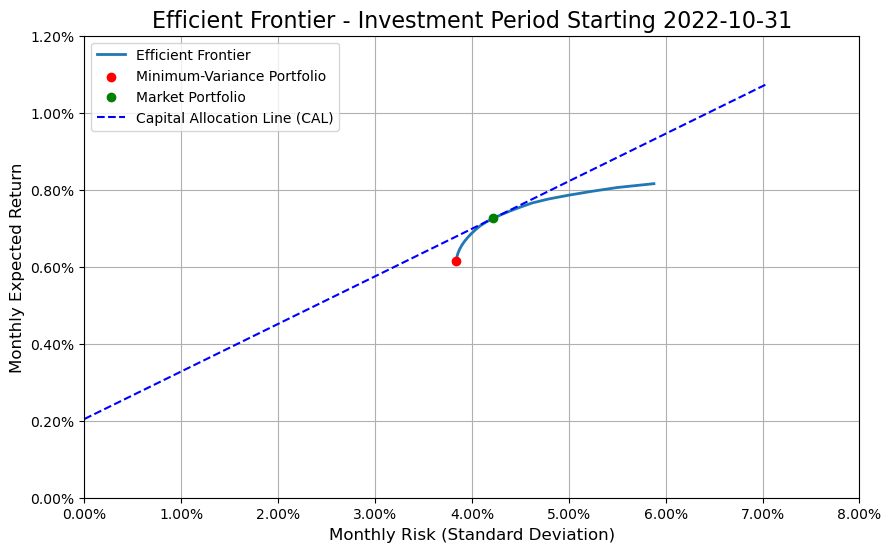

Processing interval starting at 2023-04-28 00:00:00


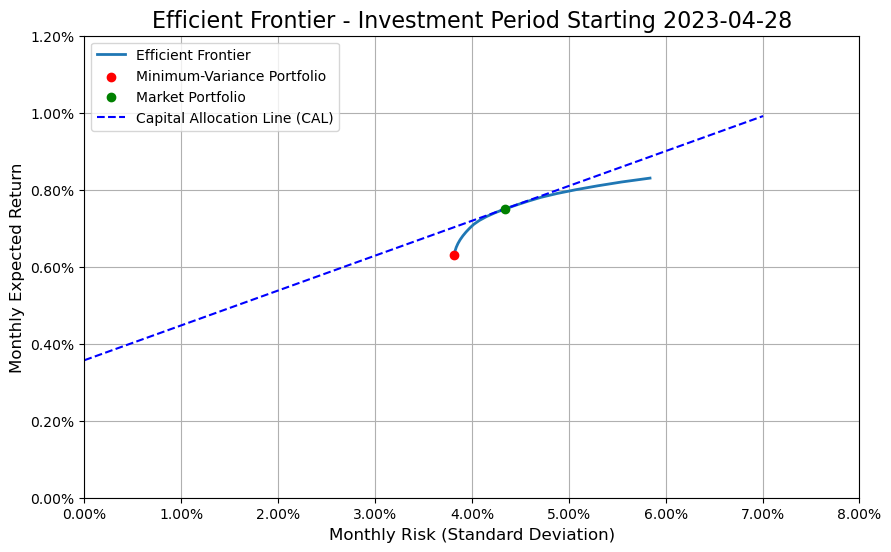

Processing interval starting at 2023-10-31 00:00:00


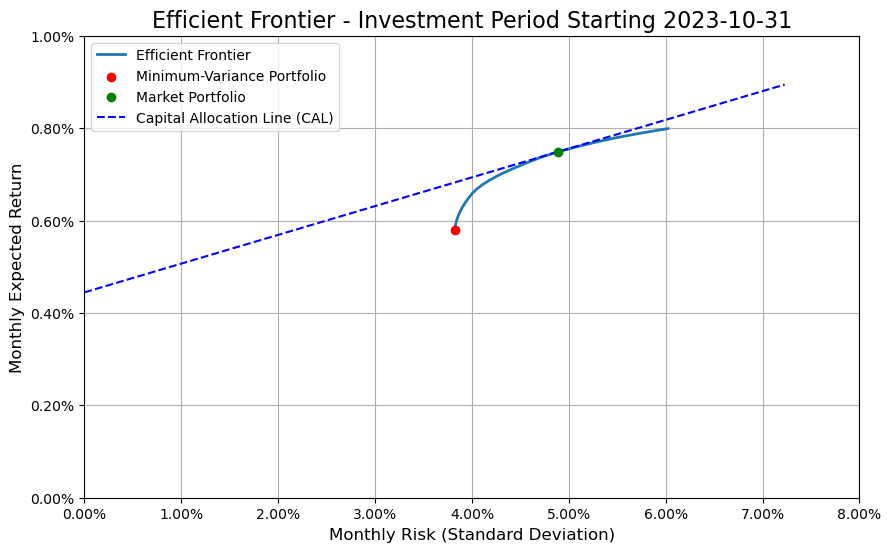

Processing interval starting at 2024-04-30 00:00:00


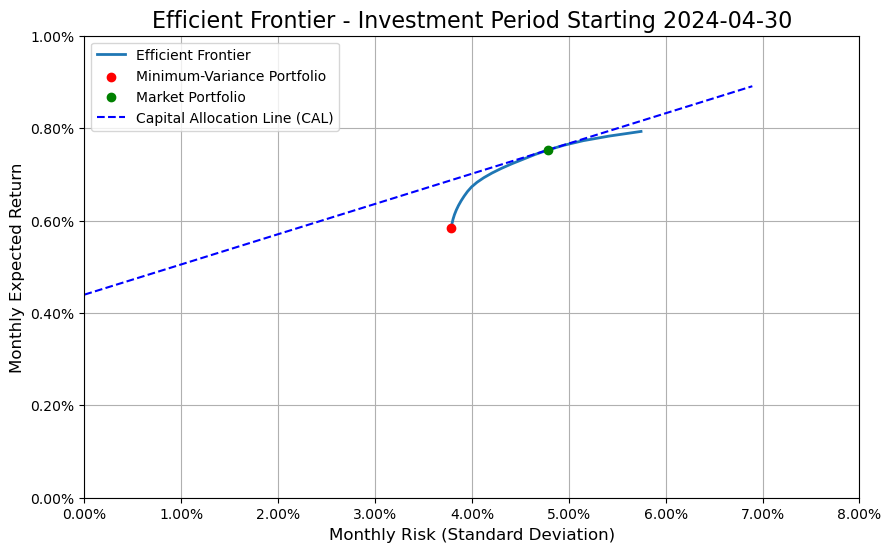

Processing interval starting at 2024-10-31 00:00:00


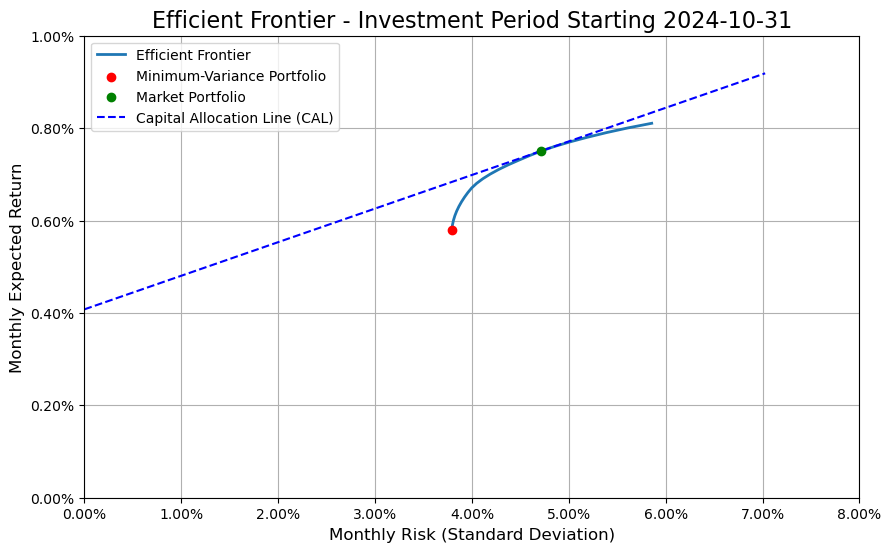


Combined Portfolio Summary:



,Date,Expected Return_MinVar,Risk_MinVar,Expected Return_Market,Risk_Market,Sharpe Ratio,BRITISH AMERICAN TOBACCO_MinVar,BRITISH AMERICAN TOBACCO_Market,BUNZL_MinVar,BUNZL_Market,NATIONAL GRID_MinVar,NATIONAL GRID_Market,VODAFONE GROUP_MinVar,VODAFONE GROUP_Market,ASTRAZENECA_MinVar,ASTRAZENECA_Market
0,2014-10-31,0.007865,0.036118,0.008565,0.038560,0.214293,0.163304,0.308660,0.206852,0.263885,0.308787,0.173532,0.121707,0.141804,0.199350,0.112118
1,2015-04-30,0.007708,0.036102,0.008508,0.038882,0.210045,0.158482,0.307114,0.209231,0.274881,0.313978,0.158122,0.116651,0.156007,0.201659,0.103876
2,2015-10-30,0.007527,0.036676,0.008427,0.039632,0.204105,0.158245,0.320053,0.209674,0.276797,0.310148,0.168868,0.116212,0.143517,0.205721,0.090766
3,2016-04-29,0.007519,0.036299,0.008519,0.039432,0.208619,0.159703,0.323801,0.211134,0.284517,0.310723,0.172422,0.115721,0.142353,0.202719,0.076907
4,2016-10-31,0.007697,0.036397,0.008597,0.039157,0.215645,0.150829,0.317446,0.209619,0.274496,0.319931,0.174150,0.125318,0.136111,0.194303,0.097796
5,2017-04-28,0.007615,0.037083,0.008815,0.040713,0.214071,0.164046,0.354973,0.218273,0.302510,0.306472,0.157080,0.123949,0.102132,0.187260,0.083305
6,2017-10-31,0.007383,0.037438,0.008483,0.040914,0.200736,0.163404,0.354108,0.228828,0.306329,0.296780,0.134071,0.123635,0.112700,0.187355,0.092792
7,2018-04-30,0.006924,0.037662,0.007824,0.040779,0.181571,0.161272,0.339829,0.230478,0.308675,0.290921,0.129284,0.126547,0.118240,0.190782,0.103973
8,2018-10-31,0.006690,0.037368,0.007690,0.041284,0.171822,0.154237,0.326596,0.237059,0.354901,0.295027,0.132910,0.121258,0.037144,0.192419,0.148449
9,2019-04-30,0.006413,0.037415,0.007313,0.041109,0.162535,0.142401,0.303499,0.239342,0.361444,0.299934,0.146034,0.123600,0.040549,0.194722,0.148474


In [ ]:
start_idx = df.index.get_loc('2014-10-31')
intervals = []
current_idx = start_idx

while current_idx < len(df.index):
    intervals.append(df.index[current_idx])
    current_idx += 6  # Move 6 steps forward

market_portfolio_details = []
min_variance_portfolio_details = []

for start_date in intervals:
    print(f"Processing interval starting at {start_date}")
    
    try:
        selected_data = df[selected_returns.keys().tolist() + [risk_free_column]].loc[:start_date]
        selected_returns = selected_data.drop(columns=[risk_free_column])
        expected_returns = selected_returns.mean()
        max_asset_return = selected_returns.mean().max()
        covariance_matrix = selected_returns.cov()
        
        # Riskfree rate for the interval
        risk_free_rate = selected_data[risk_free_column].loc[start_date]
        
        # Min Variance Portfolio with Improved Stability
        def objective(weights):
            weights = np.array(weights)
            return weights.dot(covariance_matrix).dot(weights.T)

        cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        bounds = tuple((0, 1) for x in range(len(expected_returns)))

        best_result = None
        best_fun = float('inf')

        for i in range(5):  #No of trials to find min var portfolio
            # Initial guess with small perturbation
            guess = [1. / len(expected_returns) + np.random.uniform(-0.001, 0.001) for x in range(len(expected_returns))]
            
            opt_results_minvar = minimize(objective, guess, method='SLSQP', bounds=bounds, constraints=cons)
            
            if opt_results_minvar.success and opt_results_minvar.fun < best_fun:
                best_result = opt_results_minvar
                best_fun = opt_results_minvar.fun

        min_variance_weights = best_result.x
        portfolio_expected_return_monthly = np.dot(min_variance_weights, expected_returns)
        portfolio_variance = best_result.fun
        portfolio_risk = np.sqrt(portfolio_variance)
        
        # Store Min Variance Portfolios
        min_variance_portfolio_details.append([
            start_date,
            portfolio_expected_return_monthly,
            portfolio_risk,
            min_variance_weights
        ])
        
        # Efficient Frontier
        if portfolio_expected_return_monthly > max_asset_return:
            print(f"Skipping interval {start_date} due to infeasible return range.")
            continue
        
        efficient_frontier = []

        target_return_range = np.arange(portfolio_expected_return_monthly, max_asset_return, 0.0001)
        
        for target_return in target_return_range:
            cons1 = [
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                {'type': 'eq', 'fun': lambda x: np.dot(x, expected_returns) - target_return}
            ]
            
            guess = [1./len(expected_returns) for x in range(len(expected_returns))]
            
            opt_results = minimize(objective, guess, method='SLSQP', bounds=bounds, constraints=cons1)
            if not opt_results.success:
                print(f"Efficient frontier optimization failed for target return {target_return}.")
                continue

            variance = opt_results.fun
            risk = np.sqrt(variance)
            efficient_frontier.append({
                'Weights': opt_results.x,
                'Expected Return': target_return,
                'Risk': risk,
                'Sharpe Ratio': (target_return - risk_free_rate) / risk
            })
        
        # Market Portfolio
        market_portfolio = max(efficient_frontier, key=lambda x: x['Sharpe Ratio'])
        market_weights = market_portfolio['Weights']
        market_return = market_portfolio['Expected Return']
        market_risk = market_portfolio['Risk']
        market_sharpe = market_portfolio['Sharpe Ratio']
        
        # Store Market Portfolios
        market_portfolio_details.append([
            start_date,
            market_return,
            market_risk,
            market_sharpe,
            market_weights
        ])
        
        # Plot Efficient Frontiers and save as PNG
        frontier_risks = [portfolio['Risk'] for portfolio in efficient_frontier]
        frontier_returns = [portfolio['Expected Return'] for portfolio in efficient_frontier]
        
        plt.figure(figsize=(10, 6))
        plt.plot(frontier_risks, frontier_returns, label='Efficient Frontier', linewidth=2)
        plt.scatter(frontier_risks[0], frontier_returns[0], color='red', label='Minimum-Variance Portfolio', zorder=5)
        plt.scatter(market_risk, market_return, color='green', marker='o', label='Market Portfolio', zorder=5)
        
        # CAL
        cal_x = np.linspace(0, max(frontier_risks) * 1.2, 100)
        cal_y = risk_free_rate + market_sharpe * cal_x
        plt.plot(cal_x, cal_y, color='blue', linestyle='--', label='Capital Allocation Line (CAL)')

        plt.xlim(left=0)
        plt.ylim(bottom=0)
        
        # Update title and labels
        start_date_str = start_date.strftime('%Y-%m-%d')
        plt.title(f"Efficient Frontier - Investment Period Starting {start_date_str}", fontsize=16)
        plt.xlabel("Monthly Risk (Standard Deviation)", fontsize=12)
        plt.ylabel("Monthly Expected Return", fontsize=12)
        plt.xticks(ticks=plt.xticks()[0], labels=[f"{x * 100:.2f}%" for x in plt.xticks()[0]])
        plt.yticks(ticks=plt.yticks()[0], labels=[f"{y * 100:.2f}%" for y in plt.yticks()[0]])
        plt.legend()
        plt.grid(True)
        #plt.savefig(f"efficient_frontier_{start_date_str}.png")  # Save as PNG for the report!!!
        plt.show()
        
    except Exception as e:
        print(f"Error processing interval {start_date}: {e}")

#Store values to make Q3 easier
columns = ['Date', 'Expected Return', 'Risk', 'Sharpe Ratio', 'Weights']
market_df = pd.DataFrame(market_portfolio_details, columns=columns)
minvar_columns = ['Date', 'Expected Return', 'Risk', 'Weights']
minvar_df = pd.DataFrame(min_variance_portfolio_details, columns=minvar_columns)

# Merge minvar and market portfolios
combined_df = pd.merge(minvar_df, market_df, on='Date', suffixes=('_MinVar', '_Market'))
combined_df['Weights_MinVar'] = combined_df['Weights_MinVar'].apply(lambda x: np.round(x, 6))
combined_df['Weights_Market'] = combined_df['Weights_Market'].apply(lambda x: np.round(x, 6))

# Split weights into individual columns
weight_names = ['BRITISH AMERICAN TOBACCO', 'BUNZL', 'NATIONAL GRID', 'VODAFONE GROUP', 'ASTRAZENECA']
for i, name in enumerate(weight_names):
    combined_df[name + '_MinVar'] = combined_df['Weights_MinVar'].apply(lambda x: x[i] if len(x) > i else None)
    combined_df[name + '_Market'] = combined_df['Weights_Market'].apply(lambda x: x[i] if len(x) > i else None)

combined_df = combined_df.drop(columns=['Weights_MinVar', 'Weights_Market'])

print("\nCombined Portfolio Summary:\n")
#combined_df.to_excel('combined_portfolio_summary.xlsx', index=False) # Save for the report!!!
combined_df